# GIS Handler Workbook and Examples

In [247]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Handler

In [355]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point

# precision of input coordinates, 5 decimals is about 1.1m of a commercial 'correcting' GPS unit
# this post is helpful: https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude
precision = 5

class GISHandler:
    def __init__(self, files):
        self.rasters = {}
        self.points = gpd.GeoDataFrame(columns=['x', 'y', 'result', 'geometry'], geometry='geometry')
        
        for key, src in files.items():
            if key in self.rasters:
                print('raster {} already loaded!'.format(key))
            else:
                self.rasters[key] = rasterio.open(src)
    
    def query(self, x, y):
        x, y = self.clean(x, y)
                                    
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            print('point exists, returning original data')
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y)}
        
        for key, raster in self.rasters.items():
            index = raster.index(x, y)
            try:
                 conditions[key] = raster.read(1)[index] # yes, by default this only reads the first band, but this is probably okay
            except IndexError as error:
                print('failed to read {} raster: {}'.format(key, error))    
        
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]
    
    def record(self, x, y, value):
        x, y = self.clean(x, y)
        
        if not self.points.loc[(self.points.x==x) & (self.points.y==y)].empty:
            self.points.loc[(self.points.x==x) & (self.points.y==y), 'result'] = value
            return self.points.loc[(self.points.x==x) & (self.points.y==y)]
        
        conditions = {'x': x, 'y': y, 'geometry': Point(x, y), 'result': value}
        self.points = self.points.append(conditions, ignore_index=True)
        return self.points.iloc[-1:]       
        
    def clean(self, x, y):
        return round(x, precision), round(y, precision)

## Example

In [356]:
raster_files = {'oxygen': 'data/surface-oxygen-mgpl-4326.tif'}
handler = GISHandler(raster_files)

In [361]:
handler.points

,x,y,result,geometry,oxygen
0,-70,41,NaN,POINT (-70.00000 41.00000),9.332181
1,-70,40,43,POINT (-70.00000 40.00000),NaN


In [362]:
handler.query(-70, 41)

point exists, returning original data


,x,y,result,geometry,oxygen
0,-70,41,NaN,POINT (-70.00000 41.00000),9.332181


In [359]:
handler.record(-70, 40, 43)

,x,y,result,geometry,oxygen
1,-70,40,43,POINT (-70.00000 40.00000),NaN


<AxesSubplot:>

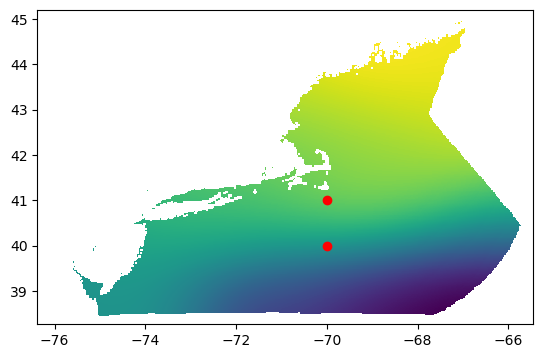

In [363]:
fig, ax = plt.subplots()
rasterio.plot.show(handler.rasters['oxygen'], ax=ax)
handler.points.plot(ax=ax, color='red')

In [8]:
handler.query(400000.000, 4400000.000, "temperature")

array([15.777459], dtype=float32)

In [9]:
handler.sample_points

,0,geometry,temperature
0,400000.0-4400000.0,POINT (400000.000 4400000.000),[15.777459]


## GeoPandas Examples

In [81]:
plt.rcParams["figure.figsize"] = [4,8]  # Set default figure size
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%config InlineBackend.figure_format = 'retina'

In [104]:
# load state and federal waters boundary
waters = gpd.read_file('data/waters-bounds-4326.geojson')
sampling = gpd.GeoDataFrame(data = data)
# load raster data
#currents = rasterio.open('data/Surface Currents.tif')
oxygen = rasterio.open('data/surface-oxygen-mgpl-4326.tif', crs=4326)

In [109]:
if 400000 in sampling.x:
    print('yes')

In [98]:
sampling

""


In [88]:
oxygen.xy(oxygen.height // 2, oxygen.width // 2)

(-70.91165559550001, 41.7350833)

In [95]:
lat = 40
lon = -70
row, col = oxygen.index(lon, lat)
oxygen.read(1)[row, col]

8.818177

<AxesSubplot:>

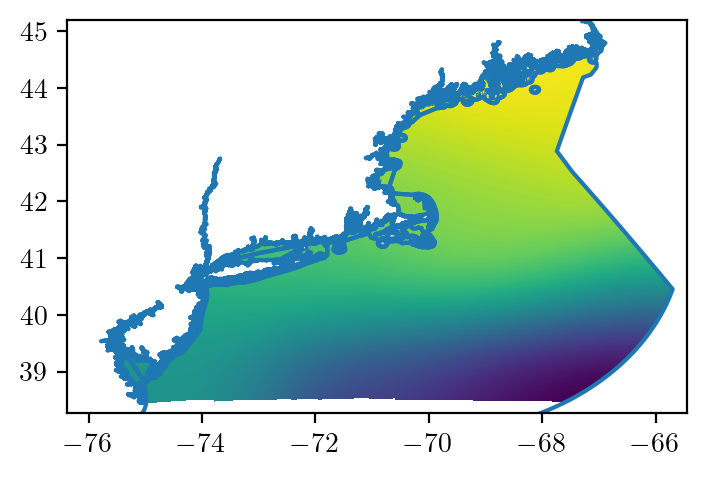

In [80]:
fig, ax = plt.subplots()

waters.boundary.plot(ax=ax)
#rasterio.plot.show(currents, ax=ax)
rasterio.plot.show(oxygen, ax=ax)

In [15]:
# load example data
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Check original projection
# (it's Plate Carrée! x-y are long and lat)
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

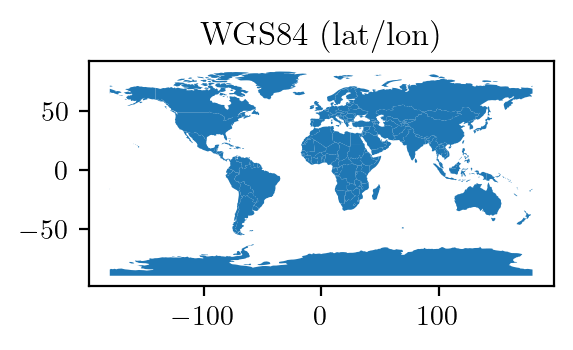

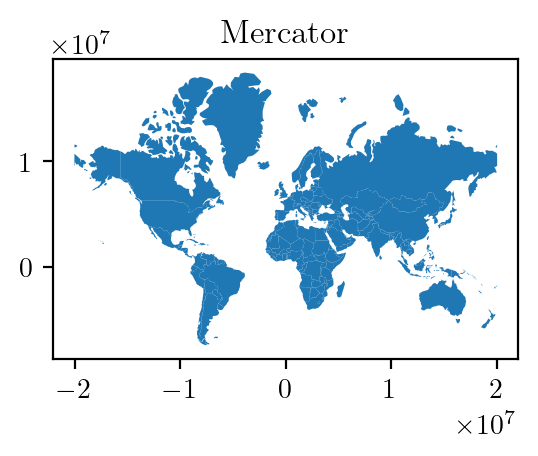

In [16]:
# Visualize
ax = world.plot()
ax.set_title("WGS84 (lat/lon)");

# Reproject to Mercator (after dropping Antartica)
world = world[(world.name != "Antarctica") & (world.name != "Fr. S. Antarctic Lands")]
world = world.to_crs("EPSG:3395") # world.to_crs(epsg=3395) would also work
ax = world.plot()
ax.set_title("Mercator");

In [4]:
# Import raster file
currents = rasterio.open('data/Surface Currents.tif')

# Create sampling points
x = [400000, 400000, 600000]
y = [4400000, 4600000, 4600000]
points = [Point(x[0], y[0]), Point(x[1], y[1]), Point(x[2], y[2])]
data = {'x': x, 'y': y, 'geometry': points}
gdf = geopandas.GeoDataFrame(data=data, crs=32630)
gdf.head()

,x,y,geometry
0,400000,4400000,POINT (400000.000 4400000.000)
1,400000,4600000,POINT (400000.000 4600000.000)
2,600000,4600000,POINT (600000.000 4600000.000)


<AxesSubplot:>

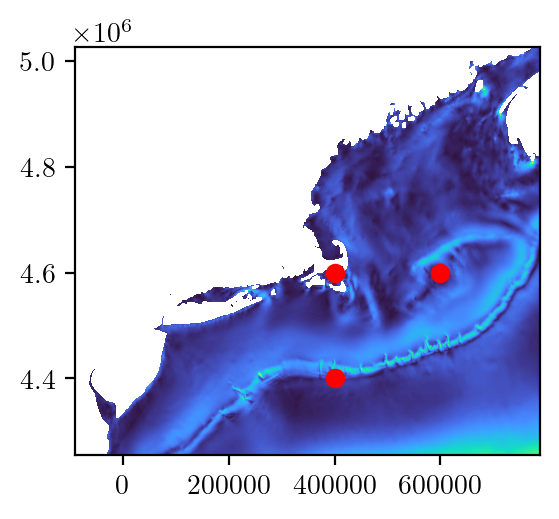

In [5]:
fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[currents.bounds[0], currents.bounds[2], currents.bounds[1], currents.bounds[3]]
ax = rasterio.plot.show(currents, extent=extent, ax=ax, cmap='turbo')

gdf.plot(ax=ax, color='red')

In [102]:
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]
gdf['current'] = [x for x in currents.sample(coord_list)]
gdf.head()

,x,y,geometry,current
0,400000,4400000,POINT (400000.000 4400000.000),"[0.0742688, 181.08922]"
1,400000,4600000,POINT (400000.000 4600000.000),"[0.08844339, 73.10852]"
2,600000,4600000,POINT (600000.000 4600000.000),"[0.04151321, 44.972664]"


In [24]:
gdf.query("x == {} & y == {}".format(x[0], y[0]))

,x,y,geometry,current
0,400000,4400000,POINT (400000.000 4400000.000),"[0.0742688, 181.08922]"


In [118]:
def ask(x_, y_, set):
    if x_ in gdf.x.values and y_ in gdf.loc[gdf.x == x_].y.values:
        gdf.loc[gdf.x == x_][gdf.y == y_]
        print('in set')
        [x for x in currents.sample([(x_, y_)])][0]
    else:
        gdf.loc[len(gdf.index)] = {'x': x_, 'y': y_, 'geometry': Point(x_, y_)}
        print('ya')

In [119]:
ask(400, 600, "currents")
gdf

ya


,x,y,geometry,current
0,400000,4400000,POINT (400000.000 4400000.000),"[0.0742688, 181.08922]"
1,400000,4600000,POINT (400000.000 4600000.000),"[0.08844339, 73.10852]"
2,600000,4600000,POINT (600000.000 4600000.000),"[0.04151321, 44.972664]"
3,400,600,POINT (400.000 600.000),NaN


In [103]:
[(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

[(400000.0, 4400000.0), (400000.0, 4600000.0), (600000.0, 4600000.0)]

In [117]:
[x for x in currents.sample([(x_, y_)])][0]

0.0


In [114]:
for i in currents.sample([(x_, y_)]):
    print(i)

[0. 0.]


## GISHandler Examples

In [6]:
import gis_handler

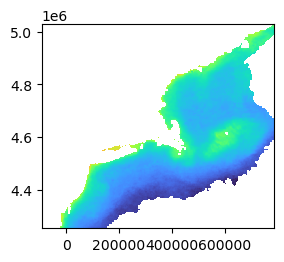

In [7]:
raster_files = {'current': 'data/Surface Currents.tif',
                'chlorophyll': 'data/Summer Chlorophyll.tif',
                'temperature': 'data/Surface Temperature.tif'}

handler = gis_handler.GISHandler()
handler.load_raster_files(raster_files)
handler.display_raster('chlorophyll')

In [8]:
handler.query(400000.000, 4400000.000, "temperature")

array([15.777459], dtype=float32)

In [9]:
handler.sample_points

,0,geometry,temperature
0,400000.0-4400000.0,POINT (400000.000 4400000.000),[15.777459]
